# Import

In [11]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import os

import package_DBR
import PACKAGE_LAB

from importlib import reload
package_DBR = reload(package_DBR)
PACKAGE_LAB = reload(PACKAGE_LAB)

from package_DBR import *
from PACKAGE_LAB import *

# Simulation parameters

In [12]:
TSim = 2000               # Simulation Time [s]
Ts = 1                     # Sampling Period [s], Ts est imposé 
N = int(TSim/Ts) + 1

# Working point
MV0 = 50
DV0 = 50
PV0 = 52.5                 # Vient de l'experience 

# Parameters Step response MV
Kp = 0.22940157900053862
T1p = 235.05979493875853  
T2p =  4.990264278507082
thetap =  50.462409314789745

# Parameters Step response DV
Kd = 0.407
T1d =  150.244  
T2d =  2.7537
thetad = 6

# Controller


# Définition du contrôleur PID si nécessaire
C = Controller({})

# Process object
P = Process({})
#P.parameters['kp'] = kp
P.parameters['kp'] = Kp
P.parameters['Tlead1'] = 0
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = thetap
P.parameters['nInt'] = 0

# Parameters PID controller
gamma = 0.6                                             
Kc, Ti, Td = IMC_TUNING(Kp,T1p,T2p,thetap,gamma,'SOPDT')
# Kc = C.parameters['Kc']
# Ti = C.parameters['Ti']
# Td = C.parameters['Td']
# print('Kc: ', Kc)
# print('Ti: ', Ti)
# print('Td: ', Td)


alpha = 1
#La puissance de chauffe est limité entre 0 et 100 %
MVMin = 0  
MVMax = 100

# 4 scénariosn de simulation

In [13]:
scenario = "CLP+FF"

# Scenario 1 : OLP + no FF  
if scenario == "OLP+noFF":
    ManPath = {0:True, TSim: True} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0:PV0, TSim: PV0}   
    DVPath = {0: 50.0, 1100: 60, TSim: 60.0}
    ActivateFF = False
    ManFF = True

    
# Scenaro 2 : OLP + FF
elif scenario == "OLP+FF":
    ManPath = {0:True, TSim: True} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0:PV0, TSim: PV0}  
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
    ActivateFF = True
    ManFF = True

# Scenaro 3 : CLP + no FF
elif scenario == "CLP+noFF":
    ManPath = {0:True, 500:False, TSim: False} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0: PV0+5, 1200: PV0-5, TSim: PV0-5} 
    DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10} 
    ActivateFF = False
    ManFF = False

# Scenaro 4 : CLP + FF
elif scenario == "CLP+FF":
    ManPath = {0:True, 500:False, TSim: False} 
    MVManPath = {0:MV0, TSim: MV0} 
    SPPath = {0: PV0+5, 1200: PV0-5, TSim: PV0-5} 
    DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10} 
    ActivateFF = True
    ManFF = False

# Closed-loop simulation with PID and FF

In [14]:
# Initialisation 
t = []

SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []


MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)
    
    # Signaux d'entrée SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    # Calcul du Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LL_RT(MVFFDelay, -Kd/Kp ,T1p ,T1d ,Ts ,MVFFLL1 )              
    if ActivateFF:
        LL_RT(MVFFLL1 ,1 , T2p , T2d , Ts,MVFF)                    
    else:
        LL_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)
        
    # PID 
    SelectPath_RT( ManPath , t , Man)      
    SelectPath_RT(MVManPath,t,MVMan)
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    # Simulation de P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    # Simulation de D(s)         
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kp,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0 - Kp * MV0)    

# Plot data

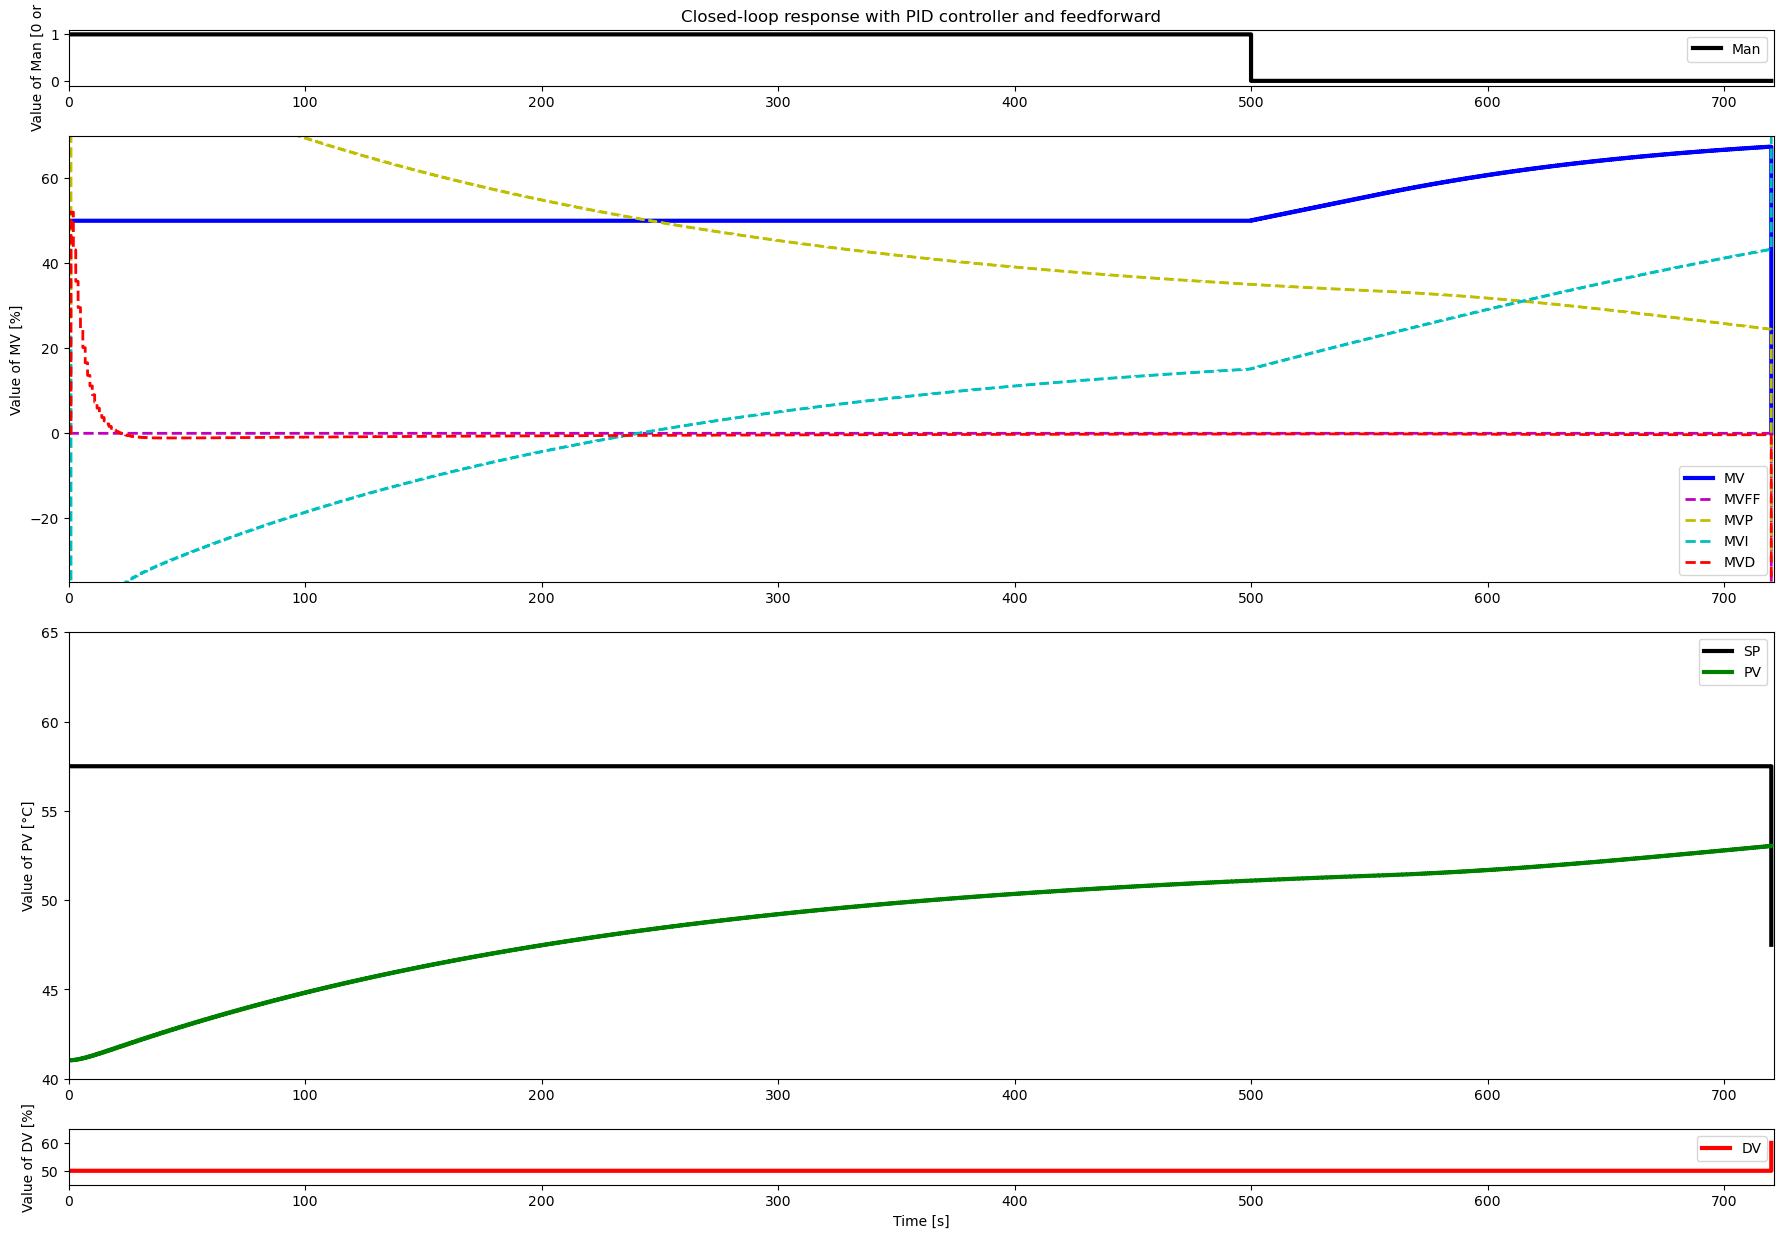

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, gridspec_kw={'height_ratios':[1, 8, 8, 1]})
fig.set_figheight(15)
fig.set_figwidth(22)

l1, = ax1.step([0,t[-1]],[0,100],'k-',linewidth=3,label="Man",where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and feedforward')
ax1.legend(loc='best')

l2, = ax2.step([0,t[-1]],[0,100],'b-',linewidth=3,label="MV",where='post')
l24, = ax2.step([0,t[-1]],[0,100],'--m',linewidth=2,label="MVFF",where='post')
l21, = ax2.step([0,t[-1]],[0,100],'--y',linewidth=2,label="MVP",where='post')
l22, = ax2.step([0,t[-1]],[0,100],'--c',linewidth=2,label="MVI",where='post')
l23, = ax2.step([0,t[-1]],[0,100],'--r',linewidth=2,label="MVD",where='post')
ax2.set_ylabel("Value of MV [%]")
ax2.legend(loc='best')

l3, = ax3.step([0,t[-1]],[0,100],'k-',linewidth=3,label="SP",where='post')
l4, = ax3.step([0,t[-1]],[0,100],'g-',linewidth=3,label="PV",where='post')
ax3.set_ylabel("Value of PV [°C]")
ax3.legend(loc='best')

l5, = ax4.step([0,t[-1]],[0,100],'r-',linewidth=3,label="DV",where='post')
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Value of DV [%]")
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]

l1.set_data(t,ManInt)
l2.set_data(t,MV)
l21.set_data(t,MVP)
l22.set_data(t,MVI)
l23.set_data(t,MVD)
l24.set_data(t,MVFF)
l3.set_data(t,SP)
l4.set_data(t,PV)
l5.set_data(t,DV)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)
ax3.set_xlim(0, t[-1]+1)
ax4.set_xlim(0, t[-1]+1)

MVMinscope = myRound(np.min([np.min(MV),np.min(MVP),np.min(MVI),np.min(MVD),np.min(MVFF)]),5)-5
MVMaxscope = myRound(np.max([np.max(MV),np.max(MVP),np.max(MVI),np.max(MVD),np.max(MVFF)]),5)+5

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(np.max([MVMinscope,-35]), np.min([MVMaxscope,70]))
ax3.set_ylim(np.max([myRound(np.min((np.min(PV),np.min(SP))),5)-5,40]), myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)

nameFile = 'Plots/Simulation_' + scenario
if not os.path.exists('Plots'):
    os.makedirs('Plots')
     